In [1]:
import os
os.chdir(r'C:\Users\Gebruiker\PycharmProjects\ComputerVision')

# Visualizing CNN Layers
In this notebook, we load a trained CNN (from a solution to FashionMNIST)
and implement several feature visualization techniques to see what features this network
has learned to extract.

### Load the data
In this cell, we load in just the test dataset from the FashionMNIST

In [2]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

test_data = FashionMNIST(root='./data', train=False,
                                  download=False, transform=data_transform)


# Print out some stats about the test data
print('Test data, number of images: ', len(test_data))

Test data, number of images:  10000


In [3]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some test data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`.
It then plots the batch of images and labels in a `2 x batch_size/2` grid.

<ipython-input-4-38059644b3bb>:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


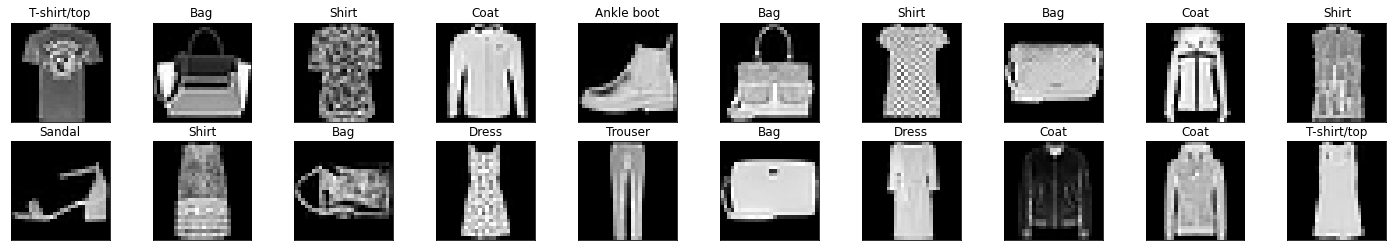

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture
The various layers that make up any neural network are documented, here.
For a convolutional neural network, we'll use a simple series of layers:
* Convolutional;
* Maxpooling Layers;
* Dropout layers;
* Fully-connected (linear) layers;

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # 1 input image channel (grayscale), 10 output channels / feature maps
        # 3x3 square convolution kernel
        # 1x28x28 => 10x26x26
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=10,
                               kernel_size=3)

        # define a MaxPool2d layer
        # 10x26x26 => 10x13x13
        self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define a dropout layer
        self.drop1 = nn.Dropout(p=0.4)

        # Define the second convolutional layer
        # 10x13x13 => 20x11x11
        self.conv2 = nn.Conv2d(in_channels=10,
                               out_channels=20,
                               kernel_size=3)

        # define a MaxPool2d layer
        # 20x11x11 => 20x5x5
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define a dropout layer
        self.drop2 = nn.Dropout(p=0.3)

        # 20x5x5 => 1x500 (flattered vector)
        self.full_connected_1 = nn.Linear(20*5*5, 32)

        # 512 => 10
        self.full_connected_2 = nn.Linear(32, 10)


    # Define the feedforward behavior
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool2d_1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2d_2(x)

        # prepare for the linear layer
        #flatten the inputs into a vector
        x = x.view(x.size(0), -1)

        x = self.drop1(x)
        x = self.full_connected_1(x)

        x = self.drop2(x)
        x = self.full_connected_2(x)
        x = F.log_softmax(x, dim=1)

        return x

### Load in our trained net
This notebook needs to know th network architecture, as defined above,
and once it knows what the "Net" class looks like, we can instantiate
a model and load in an already trained network.

In [6]:
# instantiate your Net
net = Net()

# Load the net parameters by name
net.load_state_dict(torch.load('saved models/fashion_net_simple.pt'))

print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (full_connected_1): Linear(in_features=500, out_features=32, bias=True)
  (full_connected_2): Linear(in_features=32, out_features=10, bias=True)
)


### Feature Visualization
Sometimes, neural networks are thought of as a black box, given some
input, they learn to produce some output. CNN's are actually learning
to recognize a variety of spatial patterns, and you can visualize what
each convolutional layer has been trained to recognize by at the weights
that make up each convolutional kernel and applying those one at a time
to a sample image. These techniques are called feature visualization, and
they are useful for understanding the inner workings of a CNN.

First convolutional layer


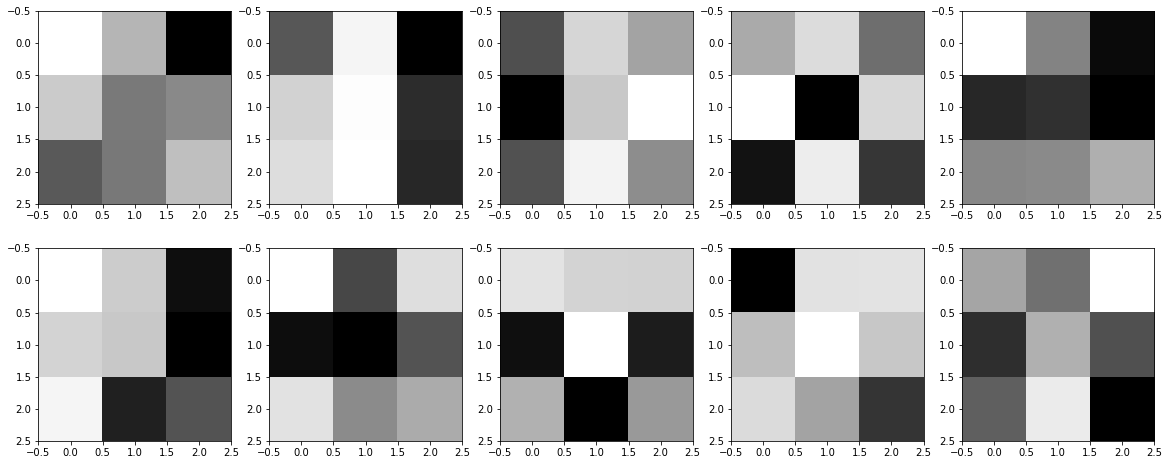

In [7]:
# Get the weights in the first con layer
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')

print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

### Activation Maps
Next, you'll see how to use OpenCV's filter2D function to apply these filters
to a sample test image and produce a series of activation maps as a result.
We'll do this for the first and second convolutional layers, and these activation maps
would really give you a sense for what features each filter learns to extract.

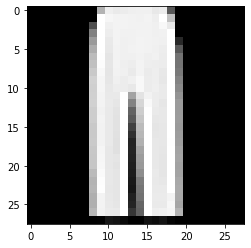

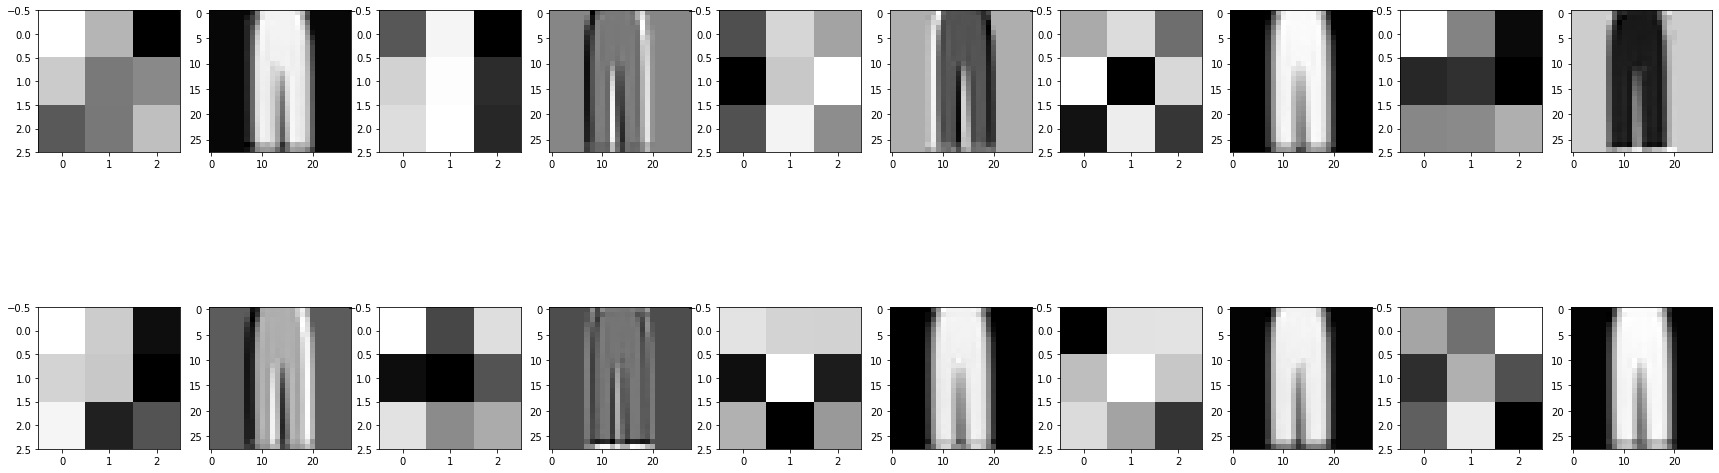

In [10]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx])
# Use OpenCV's filter2D function
# Apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. Fist conv layer
# for 10 filters
# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[i//2][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

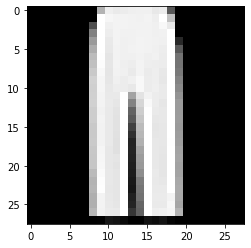

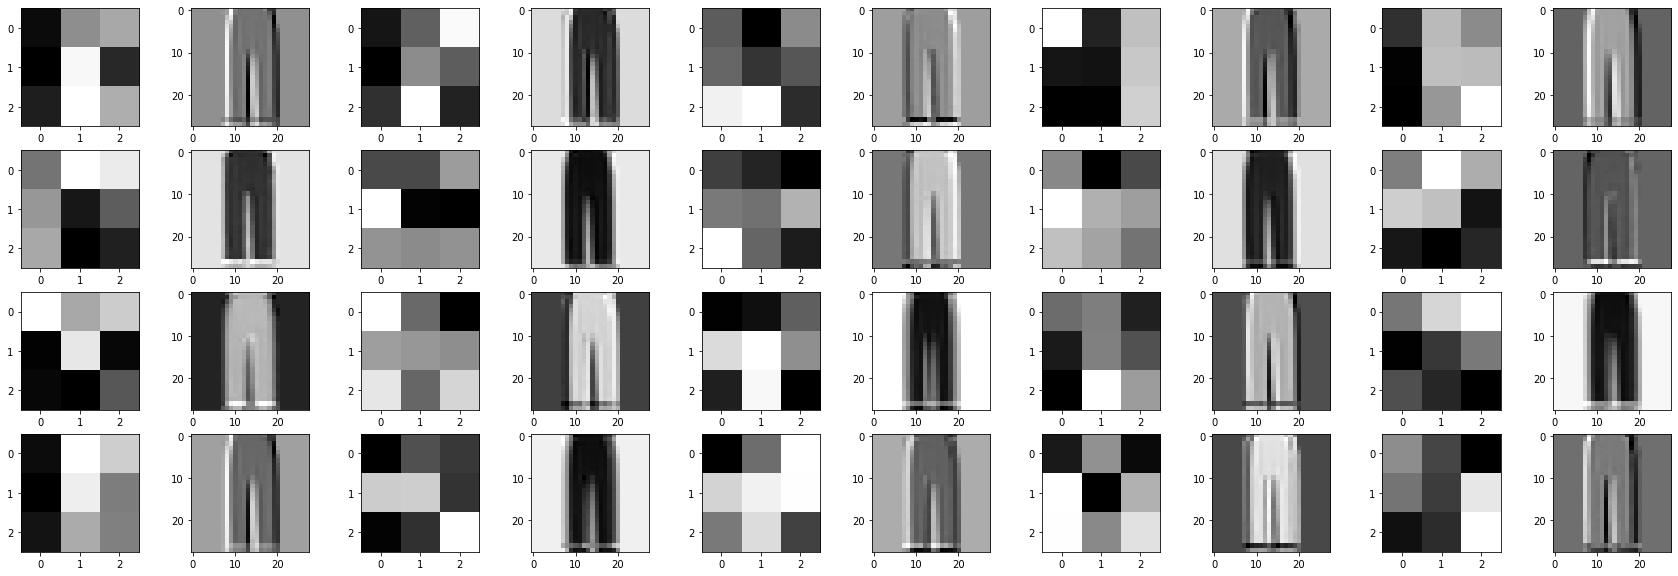

In [11]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

In [3]:
# import torch
# torch.cuda.current_device()
torch.cuda.device(0)
# torch.cuda.is_available()

In [4]:
torch.cuda.device_count()

0

In [5]:
torch.cuda.get_device_name()

AssertionError: Torch not compiled with CUDA enabled